<div class="alert alert-success">
<h1>Bayesian Logistic Regression - Metropolis-Hastings Lab</h1>
<h2>ASI Lab - 13/04/2017</h2>
</div>

<h3>Aims</h3>
<p>
<ul>
<li>To implement the MH algorithm.
<li>To use it to compute classiﬁcation probabilities.
</ul>

<div class="alert alert-info">
<h3>Metropolis-Hastings</h3>
<p>
In this lab, you’re going to implement the Metropolis-Hasting algorithm described in the lecture. Use the binary classiﬁcation data <code>binaryclass2.mat</code> and the function <code>laplacecomp.m</code>. If you pass this function a 2-dimensional $w$ vector, it will return $g(\mathbf{w}; \mathbf{X}, \mathbf{t}, \sigma^2)$ and $logg(\mathbf{w}; \mathbf{X}, \mathbf{t}, \sigma^2)$.
<br>
<br>
(Remember that $g(\mathbf{w}; \mathbf{X}, \mathbf{t}, \sigma^2) \propto p(\mathbf{w} \mid \mathbf{X}, \mathbf{t}, \sigma^2)$, the posterior density of interest.)
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy.stats import beta
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 10.0)

<div class="alert alert-warning">
We load the matlab file and we get the two variables inside it.
</div>

In [2]:
binaryclass2 = sio.loadmat("Lab2/files_lab_log_reg/binaryclass2.mat")
X = binaryclass2['X']
t = binaryclass2['t']

<div class="alert alert-warning">
We also rewrite laplacecomp.m in python since the original lab was written in matlab.
</div>

In [3]:
#laplacecomp.m rewritten in python
def laplacecomp(w, X, t):
    w = np.array(w)
    X = np.array(X)
    t = np.array(t)
    #computer g and log g for the laplace model introduced in the lecture.
    ss = 10 #prior variance
    #evaluate log prior
    logg = -(1/(2*ss))*w.transpose().dot(w)
    
    #compute P
    P = 1.0/(1+np.exp(-X.dot(w)))
    logl = sum(t * np.log(P) + (1-t) * np.log(1-P))
    logg = logg + logl
    g = np.exp(logg)
    return g[0][0], logg[0][0]

<div class="alert alert-info">
Make sure laplacecomp.m works by passing it some diﬀerent $\mathbf{w}$ vectors ($\mathbf{w}$ needs to have dimension 2 × 1).
</div>

In [4]:
w1 = np.random.randn(2,1)
w2 = np.random.randn(2,1)
w3 = np.random.randn(2,1)

print(laplacecomp(w1, X, t))
print(laplacecomp(w2, X, t))
print(laplacecomp(w3, X, t))

(0.0, -1071.1516258930831)
(1.3881348766914434e-170, -391.11150477821536)
(4.3304985249540936e-17, -37.678263912727793)


<div class="alert alert-info">
Implement the MH algorithm (see the ﬂowchart in the slides). You might ﬁnd it safest to work with $log g$ – the ratio then becomes a subtraction that must then be exponentiated. This has more numerical stability, especially when $\mathbf{w}$ isn’t very good. You can start with any value of $\mathbf{w}$. e.g. $\mathbf{w} = randn(2,1)$. Also, use a Gaussian proposal: For example: $wp=randn(2,1)*0.5+w$ where $\mathbf{w}$ is the current sample and $wp$ is the proposal and the Gaussian has standard deviation 0.5 (set this as you please).
</div>

In [5]:
#MH algorithm
w = np.random.randn(2,1)
ws = [w, ]
nrSamples = 20000

for s in np.arange(nrSamples):
    wp = np.random.randn(2,1)*0.5 + w #generate wp from p(ws|ws-1)
    w = ws[-1]
    gws, loggws = laplacecomp(w, X, t)
    gwp, loggwp = laplacecomp(wp, X, t)
    #compute acceptance ratio r
    logr = loggwp - loggws
    r = np.exp(logr)
    
    if r >= 1:
        ws.append(wp) #acceptance
    else:
        u = np.random.uniform(0,1)
        if u <= r:
            ws.append(wp) #acceptance
        else:
            ws.append(w) #rejection -> don't forget to add again the same value w

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in multiply


<div class="alert alert-info">
Compute the probability that $P(t_{new} = 1 \mid x_{new},\mathbf{X}, \mathbf{t})$ when $x_{new} = [2, −4]^T$.
<p>
Hint – compute the probability for each value of $\mathbf{w}$ using:

\begin{equation}
\frac{1}{1+exp(−\mathbf{w^{T}}x_{new})}
\end{equation}

and average!
</div>

In [6]:
x_new = np.array([2,-4])
p = 0
for w in ws:
    p += 1 / (1 + np.exp(-w.T.dot(x_new)))

p = p/len(ws)

print(p)

[ 0.23558587]


<div class="alert alert-warning">
Point $[2, -4]^T$ has probability 0.039 of being assigned to class 1.
</div>

<h3>Plotting</h3>

<div class="alert alert-warning">
Let's plot our training points and then let's try to plot the prediction contours.
</div>

In [7]:
xx = np.arange(-6, 6, 0.1)
yy = np.arange(-6, 6, 0.1)
xm, ym = np.meshgrid(xx, yy)
ws = np.array(ws)
probs = np.zeros(np.shape(xm))
for i in np.arange(nrSamples):
    probs += 1.0 / (1 + np.exp(-(ws[i,0]*xm + ws[i,1]*ym)))
probs = probs/nrSamples

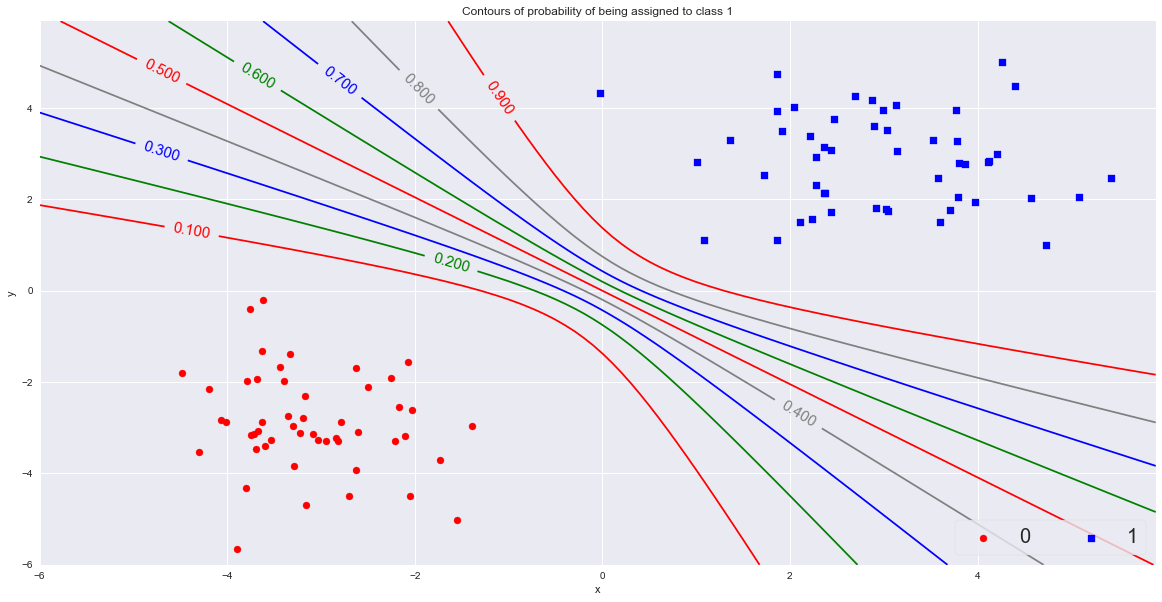

In [8]:
plt.figure()
plt.scatter(*np.array([z for y,z in enumerate(X) if t[y]==0]).reshape(2, 50), color='r', marker='o', label="0")
plt.scatter(*np.array([z for y, z in enumerate(X) if t[y]==1]).reshape(2, 50), color='b', marker='s', label="1")
CS = plt.contour(xm, ym, probs, \
                 colors=('r', 'green', 'blue', '0.5'), \
                 levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
plt.clabel(CS, inline=100, fontsize=15)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contours of probability of being assigned to class 1')
plt.legend(ncol=2, loc='lower right', frameon=True, fontsize=20)
plt.show()